In [ ]:
# Notebook is based on this:
# https://github.com/timbmg/VAE-CVAE-MNIST

# potential alternative:
# https://github.com/unnir/cVAE/blob/master/cvae.py

In [ ]:
# @title
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# general
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

# Numpyro
import numpyro
import numpyro.distributions as npdist
import random as rnd
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
from numpyro.diagnostics import hpdi

#JAX
import jax
from jax import random, grad, jit
import jax.numpy as jnp
import flax.linen as nn
from flax import serialization
import optax

from jax.tree_util import tree_map
numpyro.set_host_device_count(jax.local_device_count())
#pickle
import pickle

# check versions
print(numpyro.__version__)
print(jax.__version__)
from platform import python_version
print(python_version())

0.15.3
0.4.33
3.10.12


In [ ]:
# Set seed for reproducibility
#seed = 0
#key = jax.random.PRNGKey(seed)

# JAX automatically uses available hardware
print("JAX Device:", jax.devices()[0])

JAX Device: TFRT_CPU_0


In [ ]:
# define global arguments
args = {"seed": 0,
        "conditional": True,
        "input_dim": 80,
        "hidden_dim": 60,
        "z_dim": 40,
        "batch_size": 500,
        "samples": 100000,
        "learning_rate": 1e-3,
        "n_epochs": 400,
        "new_data": True,
        "train_vae": True,
        "save_vae": True,
        "load_vae": False,

        #"gp_kernel": exp_sq_kernel,
        "num_warmup": 2000,
        "num_samples": 5000,
        "num_chains": 3,
        "thinning": 1,
        "true_ls": 0.2
       }

In [ ]:
def dist_euclid(x, z):
    x, z = jnp.array(x), jnp.array(z)
    x = x.reshape(-1, 1) if x.ndim == 1 else x
    z = z.reshape(-1, 1) if z.ndim == 1 else z
    n_x, m = x.shape
    n_z, m_z = z.shape
    assert m == m_z
    delta = jnp.zeros((n_x, n_z))
    for d in range(m):
        x_d = x[:, d]
        z_d = z[:, d]
        delta += (x_d[:, jnp.newaxis] - z_d) ** 2
    return jnp.sqrt(delta)

def exp_sq_kernel(x, z, var, length, noise=0, jitter=1.0e-5):
    dist = dist_euclid(x, z)
    deltaXsq = jnp.power(dist / length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * jnp.eye(x.shape[0])
    return k

def GP(x, jitter=1e-5, var=1.0, length=None, y=None, noise=False, gp_kernel=exp_sq_kernel):

    if length==None:
        length = numpyro.sample("length", npdist.Uniform(0.01,0.99))

    k = gp_kernel(x, x, var, length, jitter)

    if noise==False:
        y = numpyro.sample("y",  npdist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k), obs=y)
    else:
        sigma = numpyro.sample("noise", npdist.HalfNormal(0.1))
        f = numpyro.sample("f", npdist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k))
        y = numpyro.sample("y", npdist.Normal(f, sigma), obs=y)

    ls = numpyro.deterministic("ls", jnp.array([length]))
    y_c = numpyro.deterministic("y_c", jnp.concatenate([y, ls], axis=0))

# Generate 1D GP


In [ ]:
class GP1D:
    def __init__(self, n_dataPoints=400,
                       n_samples=10000,
                       x_lim_low=0,
                       x_lim_high=1,
                       ls=None,
                       purpose = "train"
            ):
        self.n_dataPoints = n_dataPoints
        self.n_samples = n_samples
        self.x_lim_low = x_lim_low
        self.x_lim_high = x_lim_high
        self.ls = ls
        self.x, self.y, self.ls = self.__simulatedata__(purpose)

    def __simulatedata__(self,purpose):
        # Generate a JAX random key for reproducibility
        if purpose == "train":
          rng_key = 42
        else:
          rng_key = 24
        rng_key, _ = random.split(random.PRNGKey(rng_key))
        x = np.linspace(self.x_lim_low, self.x_lim_high, self.n_dataPoints)

        # Use Predictive from NumPyro to generate GP samples
        gp_predictive = Predictive(GP, num_samples=self.n_samples)
        all_draws = gp_predictive(rng_key, x=x, gp_kernel=exp_sq_kernel, jitter=1e-6, length=self.ls)

        # Extract samples and organize data
        ls_draws = np.array(all_draws['ls'])
        gp_draws = np.array(all_draws['y'])

        # Reshape x for compatibility with generated samples
        x_repeated = x.repeat(self.n_samples).reshape(self.n_dataPoints, self.n_samples).transpose()
        return x_repeated, gp_draws, ls_draws

    def __len__(self):
        return self.n_samples

    def get_item(self, idx=0):
        return self.x[idx], self.y[idx], self.ls[idx]


Input Dimension: 80
Shape of lengthscales: (10000, 1)


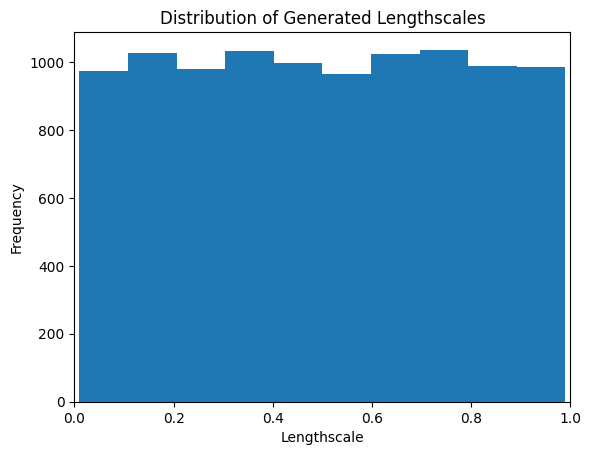

In [ ]:
# Print the input dimension being used
print("Input Dimension:", args["input_dim"])

# Create the dataset using the GP1D class
dataset = GP1D(n_dataPoints=args["input_dim"])

# Access the generated lengthscales
ls_dataset = dataset.ls
print("Shape of lengthscales:", ls_dataset.shape)

# Plot histogram of lengthscales
plt.hist(ls_dataset, bins=10)  # Adjust bin count for clarity if needed
plt.xlim(0, 1)
plt.xlabel("Lengthscale")
plt.ylabel("Frequency")
plt.title("Distribution of Generated Lengthscales")
plt.show()
#print(dataset.ls)
#print(dataset.x)
#print(dataset.y)

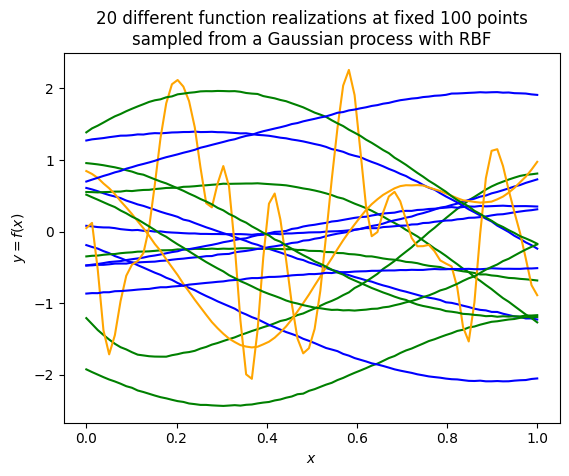

In [ ]:
# Initialize figure and axis for plotting
fig, ax = plt.subplots()

for no in range(len(dataset)):
    x, y, ls = dataset.get_item(no)

    # Determine color based on lengthscale
    if ls <= 0.2:
        col = 'orange'
    elif ls <= 0.6:
        col = 'green'
    else:
        col = 'blue'

    # Plot the function realization
    ax.plot(x.reshape(-1, 1), y.reshape(-1, 1), color=col)
    if no > 15: break

# Set plot labels and title
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('20 different function realizations at fixed 100 points\n'
             'sampled from a Gaussian process with RBF')

# Display the plot
plt.show()


Generating new data


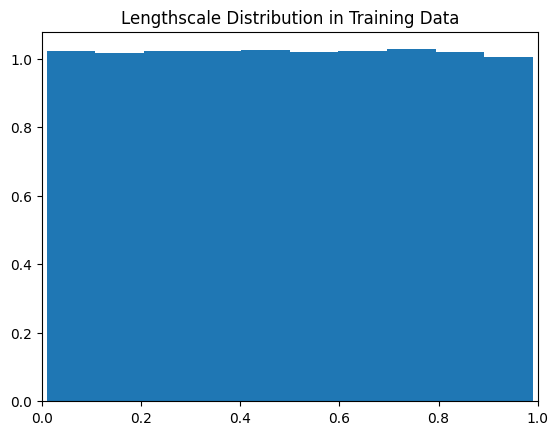

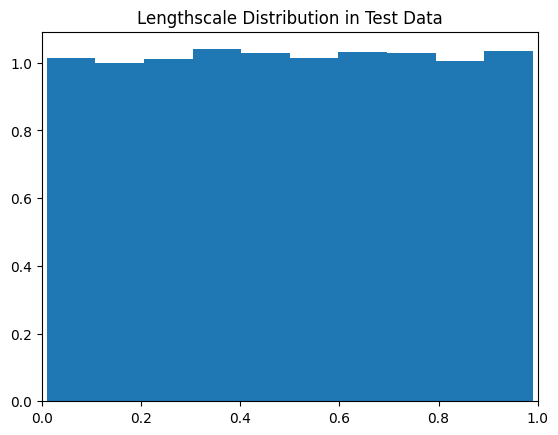

In [ ]:
###### create or read training and test data
cwd = os.getcwd()
train_ds_name = f'gp1d_n{args["input_dim"]}_train.pkl'
test_ds_name = f'gp1d_n{args["input_dim"]}_test.pkl'
PATH_train = os.path.join(cwd, "data", "gp1d", train_ds_name)
PATH_test = os.path.join(cwd, "data", "gp1d", test_ds_name)

# Ensure the directory exists
os.makedirs(os.path.dirname(PATH_train), exist_ok=True)
os.makedirs(os.path.dirname(PATH_test), exist_ok=True)

if args["new_data"]:
    print("Generating new data")
    train_ds = GP1D(n_dataPoints=args["input_dim"], n_samples=args["samples"],purpose = "train")
    test_ds = GP1D(n_dataPoints=args["input_dim"], n_samples=args["samples"],purpose = "test")
    # Save using pickle
    with open(PATH_train, 'wb') as f:
        pickle.dump(train_ds, f)
    with open(PATH_test, 'wb') as f:
        pickle.dump(test_ds, f)
else:
    print("Loading data")
    with open(PATH_train, 'rb') as f:
        train_ds = pickle.load(f)
    with open(PATH_test, 'rb') as f:
        test_ds = pickle.load(f)

# Manual batching function
def create_batches(dataset, batch_size):
    indices = np.arange(len(dataset))
    # np.random.shuffle(indices)
    for start_idx in range(0, len(dataset), batch_size):
        batch_indices = indices[start_idx:start_idx + batch_size]
        yield [dataset.get_item(i) for i in batch_indices]

# Example usage of create_batches for training and testing
train_batches = list(create_batches(train_ds, args["batch_size"]))
test_batches = list(create_batches(test_ds, args["batch_size"]))

# Check distribution of lengthscales in training and test data
plt.hist(train_ds.ls, density=True)
plt.xlim(0, 1)
plt.title("Lengthscale Distribution in Training Data")
plt.show()

plt.hist(test_ds.ls, density=True)
plt.xlim(0, 1)
plt.title("Lengthscale Distribution in Test Data")
plt.show()


# CVAE Architecture

In [ ]:
class Encoder(nn.Module):
    input_dim: int
    hidden_dim: int
    z_dim: int
    conditional: bool = False

    @nn.compact
    def __call__(self, x, c=None):
        # Adjust input if conditional
        if self.conditional and c is not None:
            c = jnp.reshape(c, (x.shape[0], -1))  # Reshape c to match batch size
            x = jnp.concatenate([x, c], axis=-1)
        hidden = nn.Dense(self.hidden_dim)(x)
        hidden = nn.relu(hidden)
        z_mu = nn.Dense(self.z_dim)(hidden)
        z_sd = nn.Dense(self.z_dim)(hidden)

        return z_mu, z_sd

class Decoder(nn.Module):
    z_dim: int
    hidden_dim: int
    input_dim: int
    conditional: bool = False

    @nn.compact
    def __call__(self, z, c=None):
        # Concatenate condition if conditional
        if self.conditional and c is not None:
            c = jnp.reshape(c, (z.shape[0], -1))  # Reshape c to match batch size
            z = jnp.concatenate([z, c], axis=-1)

        hidden = nn.Dense(self.hidden_dim)(z)
        hidden = nn.relu(hidden)
        pred = nn.Dense(self.input_dim)(hidden)

        return pred

class VAE(nn.Module):
    input_dim: int
    hidden_dim: int
    latent_dim: int
    conditional: bool = False

    def setup(self):
        self.encoder = Encoder(self.input_dim, self.hidden_dim, self.latent_dim, self.conditional)
        self.decoder = Decoder(self.latent_dim, self.hidden_dim, self.input_dim, self.conditional)

    def reparameterize(self,z_mu, z_sd,eps = None, is_training=True):
        '''During training, sample from the learned Z-dimensional normal distribution using NumPy.
          During inference, use the mean (z_mu).
        '''
        if is_training:
            # Convert log variance to standard deviation
            std = jnp.exp(z_sd / 2)
            # get the initial state of the RNG
            # random epsilon vector not given as input
            if eps == None:
              eps = np.random.normal(0, 1, size=std.shape).astype(np.float32)
            eps = jnp.array(eps)  # Convert NumPy array to JAX array
            # Reparameterize: return sampled latent variable
            return eps * std + z_mu
        else:
            # During inference, return the mean without sampling
            return z_mu

    def __call__(self, x, eps = None, c=None, is_training=True):
        # Encode input to obtain mean and std dev of latent distribution
        z_mu, z_sd = self.encoder(x, c)

        # Reparameterize
        z = self.reparameterize(z_mu, z_sd, eps, is_training)

        # Decode to reconstruct input
        generated_x = self.decoder(z, c)
        return generated_x, z_mu, z_sd

    def decode(self, z, c=None):
        return self.decoder(z, c)

In [ ]:
class Decoder(nn.Module):
    z_dim: int
    hidden_dim: int
    input_dim: int
    conditional: bool = False

    @nn.compact
    def __call__(self, z, c=None):
        # Concatenate condition if conditional
        if self.conditional and c is not None:
            c = jnp.reshape(c, (z.shape[0], -1))  # Reshape c to match batch size
            z = jnp.concatenate([z, c], axis=-1)

        hidden = nn.Dense(self.hidden_dim)(z)
        hidden = nn.relu(hidden)
        pred = nn.Dense(self.input_dim)(hidden)

        return pred

In [ ]:
class VAE(nn.Module):
    input_dim: int
    hidden_dim: int
    latent_dim: int
    conditional: bool = False

    def setup(self):
        self.encoder = Encoder(self.input_dim, self.hidden_dim, self.latent_dim, self.conditional)
        self.decoder = Decoder(self.latent_dim, self.hidden_dim, self.input_dim, self.conditional)

    def reparameterize(self,z_mu, z_sd,eps = None, is_training=True):
        '''During training, sample from the learned Z-dimensional normal distribution using NumPy.
          During inference, use the mean (z_mu).
        '''
        if is_training:
            # Convert log variance to standard deviation
            std = jnp.exp(z_sd / 2)
            # jax.debug.print("x: {}",std[0][0])
            # get the initial state of the RNG
            # st0 = np.random.get_state()[1][0]
            # jax.debug.print("x: {}",st0)
            # random epsilon vector not given as input
            if eps == None:
              eps = np.random.normal(0, 1, size=std.shape).astype(np.float32)
            # jax.debug.print("x: {}",eps[0][0])
            eps = jnp.array(eps)  # Convert NumPy array to JAX array
            # Reparameterize: return sampled latent variable
            # jax.debug.print("x: {}",z_mu[0][0])
            return eps * std + z_mu
        else:
            # During inference, return the mean without sampling
            return z_mu

    def __call__(self, x, eps = None, c=None, is_training=True):
        # Encode input to obtain mean and std dev of latent distribution
        z_mu, z_sd = self.encoder(x, c)

        # Reparameterize
        z = self.reparameterize(z_mu, z_sd, eps, is_training)

        # Decode to reconstruct input
        generated_x = self.decoder(z, c)
        # jax.debug.print("x: {}",generated_x)
        return generated_x, z_mu, z_sd

    def decode(self, z, c=None):
        return self.decoder(z, c)

In [ ]:
def calculate_loss(y, reconstructed_y, mean, log_sd):
    # Reconstruction Loss (Mean Squared Error)
    RCL = jnp.sum(jnp.square(reconstructed_y - y))  # Sum of squared differences

    # KL Divergence
    KLD = -0.5 * jnp.sum(1 + log_sd - jnp.square(mean) - jnp.exp(log_sd))

    return RCL + KLD


# Train Model

In [ ]:
# Set a random seed for NumPy to ensure consistent weight initialization
seed = 42
rng_key = jax.random.PRNGKey(seed)
subkey = rng_key[1]
np.random.seed(42)
# 1) Model setup
input_dim = args["input_dim"]
hidden_dim = args["hidden_dim"]
z_dim = args["z_dim"]
conditional = args["conditional"]

# Define a custom initialization function using NumPy
def initialize_params_with_numpy(params):
    initialized_params = {}

    # Traverse through the nested dictionary structure
    for layer_name, layer_params in params.items():
        initialized_layer = {}
        for param_name, param_value in layer_params.items():
            if isinstance(param_value, dict):
                # If there are further nested layers, initialize recursively
                initialized_layer[param_name] = initialize_params_with_numpy(param_value)
            else:
                # Set weights and biases with NumPy
                shape = param_value.shape
                if "kernel" in param_name:
                    # Transpose the shape to match PyTorch convention
                    transposed_shape = (shape[1], shape[0])
                    # print(transposed_shape)
                    # Generate weights and then transpose the resulting matrix
                    weights = np.random.normal(0, 0.1, transposed_shape).T
                    initialized_layer[param_name] = jnp.array(weights, dtype=jnp.float32)
                elif  "bias" in param_name:
                    initialized_layer[param_name] = jnp.array(np.random.normal(0, 0.1, shape), dtype=jnp.float32)
                else:
                    initialized_layer[param_name] = param_value
        initialized_params[layer_name] = initialized_layer
    return initialized_params

# Initialize the VAE model
model = VAE(input_dim, hidden_dim, z_dim, conditional)
# Initialize the VAE model and get initial parameters
st0 = np.random.get_state()[1][0]
params = model.init(rng_key, x=jnp.ones((1, input_dim)), c=jnp.array([1]), is_training=True)
st0 = np.random.get_state()[1][0]
# Apply NumPy-based initialization
np.random.seed(42)
params = initialize_params_with_numpy(params)
# 2) Optimizer setup
learning_rate = args["learning_rate"]
optimizer = optax.adam(learning_rate)
# Initialize the optimizer state
opt_state = optimizer.init(params)
# Loss history tracking
loss_history_train = []
loss_history_test = []

Epoch 10, loss train: 11.938, Test Loss: 9.8951
Epoch 20, loss train: 11.196, Test Loss: 9.4333
Epoch 30, loss train: 10.756, Test Loss: 8.9457
Epoch 40, loss train: 10.64, Test Loss: 8.7753
Epoch 50, loss train: 10.44, Test Loss: 8.5359
Epoch 60, loss train: 10.344, Test Loss: 8.4736
Epoch 70, loss train: 10.223, Test Loss: 8.366
Epoch 80, loss train: 10.184, Test Loss: 8.2771
Epoch 90, loss train: 10.164, Test Loss: 8.3312
Epoch 100, loss train: 10.148, Test Loss: 8.2545
Epoch 110, loss train: 10.13, Test Loss: 8.231
Epoch 120, loss train: 10.055, Test Loss: 8.1559
Epoch 130, loss train: 10.024, Test Loss: 8.087
Epoch 140, loss train: 10.011, Test Loss: 8.0905
Epoch 150, loss train: 10.007, Test Loss: 8.1191
Epoch 160, loss train: 10.006, Test Loss: 8.1058
Epoch 170, loss train: 9.9978, Test Loss: 8.0896
Epoch 180, loss train: 9.9847, Test Loss: 8.0558
Epoch 190, loss train: 9.9695, Test Loss: 8.057
Epoch 200, loss train: 9.9707, Test Loss: 8.1002
Epoch 210, loss train: 9.9307, Test 

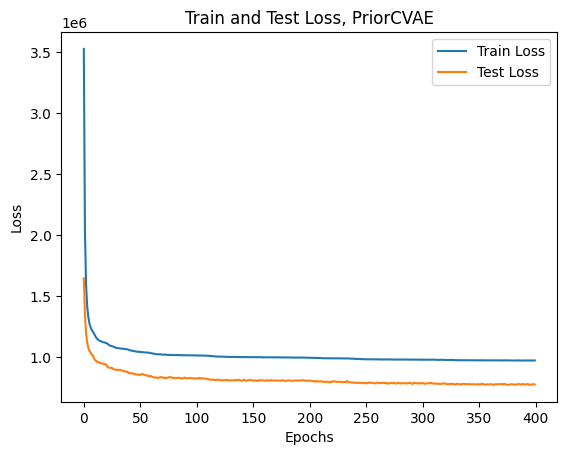

In [ ]:
# JIT compilation for efficiency
@jit
def compute_loss(params, x, c, eps=None):
    reconstructed_x, z_mu, z_sd = model.apply(params, x=x, c=c, eps = eps,is_training=True)
    # jax.debug.print("{},{},{}",reconstructed_x[0][0],z_mu[0][0],z_sd[0][0])
    return calculate_loss(x, reconstructed_x, z_mu, z_sd)

@jit
def update(params, opt_state, x, c,eps = None):
    loss, grads = jax.value_and_grad(compute_loss)(params, x, c,eps)
    updates, opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state, loss

# Training loop
num_epochs = args["n_epochs"]
np.random.seed(67)
loss_history_train = []
loss_history_test = []
st0 = np.random.get_state()[1][0]
for epoch in range(num_epochs):
    # Training
    total_loss_train = 0
    for batch in create_batches(train_ds, args["batch_size"]):
        # Unpack batch into separate lists and convert to arrays
        x, y, c = zip(*batch)
        x, y, c = jnp.array(x), jnp.array(y), jnp.array(c)
        epsilon = np.random.normal(0, 1, size=(len(batch),args["z_dim"])).astype(np.float32)
        # print(y.sum())
        params, opt_state, loss_train = update(params, opt_state, y, c if args["conditional"] else None, epsilon)
        total_loss_train += loss_train

    loss_history_train.append(total_loss_train)

    # Testing
    total_loss_test = 0
    for batch in create_batches(test_ds, args["batch_size"]):
        x, y, c = zip(*batch)
        x, y, c = jnp.array(x), jnp.array(y), jnp.array(c)

        # Forward pass without gradient computation
        reconstructed_y, z_mu, z_sd = model.apply(params, x=y, c=c if args["conditional"] else None, is_training=False)
        loss_test = calculate_loss(y, reconstructed_y, z_mu, z_sd)
        total_loss_test += loss_test

    loss_history_test.append(total_loss_test )

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}, loss train: {loss_history_train[-1]/(args["samples"]):.5}, Test Loss: {loss_history_test[-1]/(args["samples"]):.5}')

# Plotting losses
plt.figure()
plt.plot(np.arange(len(loss_history_train)), loss_history_train, label="Train Loss")
plt.plot(np.arange(len(loss_history_test)), loss_history_test, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Train and Test Loss, PriorCVAE")
plt.show()


In [ ]:
# Get current working directory
cwd = os.getcwd()

# Define the directory path for saving the model
save_dir = os.path.join(cwd, "trained_models")
os.makedirs(save_dir, exist_ok=True)

# Define model and loss filenames
model_save_name = f'PriorCVAE_gp1d_n{args["input_dim"]}_h{args["hidden_dim"]}_z{args["z_dim"]}_epochs{args["n_epochs"]}_continuous.pkl'
loss_train_name = f'CVAE_loss_train_gp1d_n{args["input_dim"]}_h{args["hidden_dim"]}_z{args["z_dim"]}_epochs{args["n_epochs"]}.pkl'
loss_test_name = f'CVAE_loss_test_gp1d_n{args["input_dim"]}_h{args["hidden_dim"]}_z{args["z_dim"]}_epochs{args["n_epochs"]}.pkl'
print(model_save_name)
print(loss_train_name)
print(loss_test_name)

# Define path for the model file
model_path = os.path.join(save_dir, model_save_name)

# Saving the model and loss history
if args["save_vae"]:
    print("Saving CVAE model and loss history...")

    # Serialize model parameters
    with open(model_path, "wb") as f:
        f.write(serialization.to_bytes(params))

    # Save loss histories
    with open(loss_train_name, "wb") as fp:
        pickle.dump(loss_history_train, fp)
    with open(loss_test_name, "wb") as fp:
        pickle.dump(loss_history_test, fp)

elif args["load_vae"]:
    print("Loading CVAE model and loss history...")

    # Load model parameters
    with open(model_path, "rb") as f:
        params = serialization.from_bytes(params, f)

    # Load loss histories
    with open(loss_train_name, "rb") as fp:
        loss_history_train = pickle.load(fp)
    with open(loss_test_name, "rb") as fp:
        loss_history_test = pickle.load(fp)

    print("CVAE model and loss history loaded")
else:
    print("No model loaded or saved.")


PriorCVAE_gp1d_n80_h60_z40_epochs400_continuous.pkl
CVAE_loss_train_gp1d_n80_h60_z40_epochs400.pkl
CVAE_loss_test_gp1d_n80_h60_z40_epochs400.pkl
Saving CVAE model and loss history...


## Visual diagnostics and how well we have learned

In [ ]:
def MMD(x, y, kernel="multiscale"):
    """Empirical maximum mean discrepancy. The lower the result, the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type, either "multiscale" or "rbf"
    """
    # Compute pairwise dot products
    xx = jnp.dot(x, x.T)
    yy = jnp.dot(y, y.T)
    zz = jnp.dot(x, y.T)

    # Calculate squared distances
    rx = jnp.diag(xx)[jnp.newaxis, :].T
    ry = jnp.diag(yy)[jnp.newaxis, :].T

    dxx = rx + rx.T - 2 * xx
    dyy = ry + ry.T - 2 * yy
    dxy = rx + ry.T - 2 * zz

    # Initialize result matrices
    XX = jnp.zeros_like(xx)
    YY = jnp.zeros_like(yy)
    XY = jnp.zeros_like(zz)

    # Apply kernel functions
    if kernel == "multiscale":
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 / (a**2 + dxx)
            YY += a**2 / (a**2 + dyy)
            XY += a**2 / (a**2 + dxy)

    elif kernel == "rbf":
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += jnp.exp(-0.5 * dxx / a)
            YY += jnp.exp(-0.5 * dyy / a)
            XY += jnp.exp(-0.5 * dxy / a)

    return jnp.mean(XX + YY - 2 * XY)


In [ ]:
def demo_plots(conditional=False,
               ttl1="GP priors to encode",
               ttl2="Priors learnt by VAE",
               ylbl1='$y=f_{GP}(x)$',
               ylbl2='$y=f_{VAE}(x)$',
               ls=None):

    n_samps = 100000
    dataset = GP1D(n_dataPoints=args["input_dim"], n_samples=n_samps, ls=ls)
    # print(dataset)
    gp_draws = dataset.y
    # print("GP Draws:", gp_draws)
    x = dataset.x[0, :]
    # print("x",x)
    gp_draws = gp_draws.T

    # Update titles and labels if conditional
    if conditional:
        ttl2 = "Priors learnt by CVAE"
        ylbl2 = '$y=f_{CVAE}(x)$'
    z = np.random.normal(size = (n_samps, z_dim)).astype(np.float32)
    z = jnp.array(z)  # random draw for z
    # print("z",z)
    # Generate VAE draws
    if conditional:
        c = jnp.ones((n_samps, 1)) * ls
        # print(c)
        vae_draws = model.apply(params, z=z, c=c, method=model.decode).T
    else:
        vae_draws = model.apply(params, z=z, c=None, method=model.decode).T

    # Calculate quantiles and means
    # print("vae_draws",vae_draws)
    mean_gp = jnp.nanmean(gp_draws, axis=1)
    q025_gp = jnp.quantile(gp_draws, 0.025, axis=1)
    q975_gp = jnp.quantile(gp_draws, 0.975, axis=1)

    mean_vae = jnp.nanmean(vae_draws, axis=1)
    q025_vae = jnp.quantile(vae_draws, 0.025, axis=1)
    q975_vae = jnp.quantile(vae_draws, 0.975, axis=1)

    #print("q025: ")
    #print(q025_gp)
    #print(q025_vae)
    #print("q975: ")
    #print(q975_gp)
    #print(q975_vae)

    # Plot results
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
    _min, _max = -3, 3
    lines_alpha_gp = 0.5
    lines_alpha_vae = 0.5
    N_lines = 20

    # Plot GP draws
    for j in range(N_lines):
        itr = int(gp_draws.shape[1] / N_lines)
        axs[0].plot(x, gp_draws[:, j * itr], alpha=lines_alpha_gp, label="")

    axs[0].plot(x, gp_draws[:,0], alpha=lines_alpha_gp, color="darkgreen", label="GP draws")
    axs[0].fill_between(x, q025_gp, q975_gp, alpha=0.1, label="95% BCI")
    axs[0].plot(x, mean_gp, label="mean")
    axs[0].legend(loc=4)
    axs[0].set_ylim([_min, _max])
    axs[0].set_xlabel('$x$')
    axs[0].set_ylabel(ylbl1)
    axs[0].set_title(ttl1 if ls is None else f"{ttl1}, ls={ls}")

    # Plot VAE draws
    for j in range(N_lines):
        itr = int(vae_draws.shape[1] / N_lines)
        axs[1].plot(x, vae_draws[:, j * itr], alpha=lines_alpha_vae)

    axs[1].plot(x, vae_draws[:,0], alpha=lines_alpha_vae, color="darkgreen", label="VAE draws")
    axs[1].fill_between(x, q025_vae, q975_vae, alpha=0.1, label="95% BCI")
    axs[1].plot(x, mean_vae, label="mean")
    axs[1].legend(loc=4)
    axs[1].set_ylim([_min, _max])
    axs[1].set_xlabel('$x$')
    axs[1].set_ylabel(ylbl2)
    axs[1].set_title(ttl2 if ls is None else f"{ttl2}, ls={ls}")

    # Combined plot for GP and VAE means
    axs[2].fill_between(x, q025_gp, q975_gp, alpha=0.1)
    axs[2].plot(x, mean_gp, label="GP mean")
    axs[2].plot(x, mean_vae, label="VAE mean")
    axs[2].legend(loc=4)
    axs[2].set_ylim([_min, _max])

    plt.show()

    # Covariance matrices
    m_vae = np.cov(vae_draws)
    m_gp = np.cov(gp_draws)
    print('Frobenius norm =', np.linalg.norm(m_gp - m_vae, 'fro'))

    # MMD calculation
    print('MMD, multiscale =', MMD(jnp.array(gp_draws), jnp.array(vae_draws)))
    print('MMD, rbf =', MMD(jnp.array(gp_draws), jnp.array(vae_draws), "rbf"))

    # Covariance matrix plots
    cmap_choice = 'inferno'
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    axs[0].imshow(m_gp, cmap=cmap_choice)
    axs[0].axis('off')
    axs[0].set_title(f'GP covariance matrix{", c=" + str(ls) if ls is not None else ""}')

    axs[1].imshow(m_vae, cmap=cmap_choice)
    axs[1].axis('off')
    axs[1].set_title(f'VAE covariance matrix{", c=" + str(ls) if ls is not None else ""}')

    plt.show()

In [ ]:
# there plots create motivation:
# 1).     unceratinty interval does not exactly match the oroginal one. This is due to the MSE loss.
#         We can change it either to likelihood with variance which is not one, or use beta-VAE, or MMD.
# 2).     VAE has learnt the best draws with ls=0.5 (Frob norm = 5.7)
# 3), 4). VAE has not learnt draws with ls values on the edge of the interval well (Frob norm = 20.3)

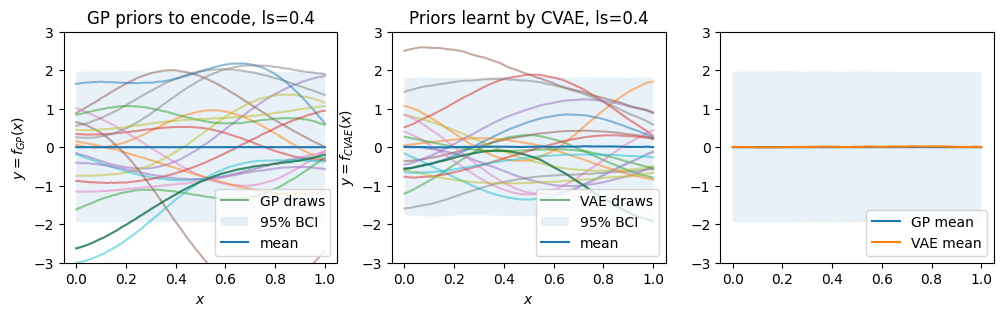

Frobenius norm = 8.266510302446843
MMD, multiscale = 0.10251313
MMD, rbf = 0.13184136


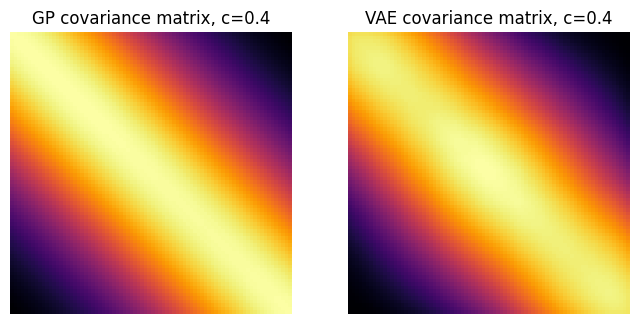

In [ ]:
# 2).
np.random.seed(36)
demo_plots(conditional=True, ls=0.4)

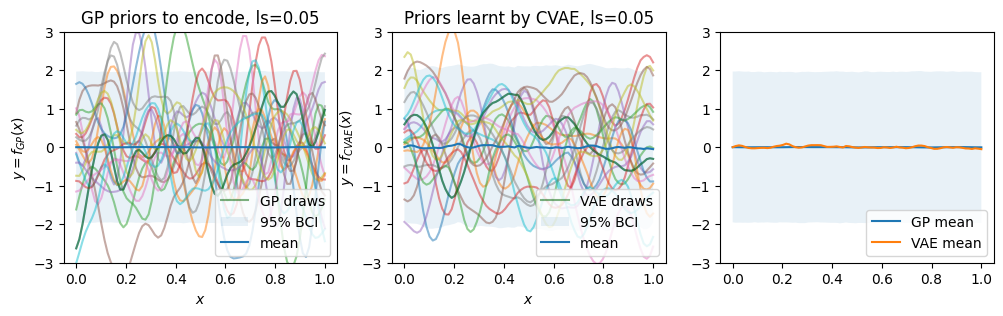

Frobenius norm = 21.370933885528473
MMD, multiscale = 0.10005593
MMD, rbf = 0.100001134


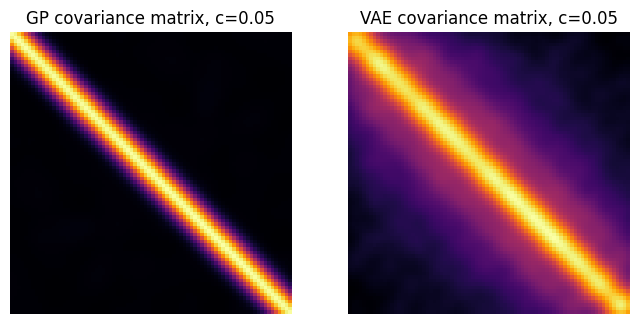

In [ ]:
# 3).
demo_plots(conditional=True, ls=0.05)

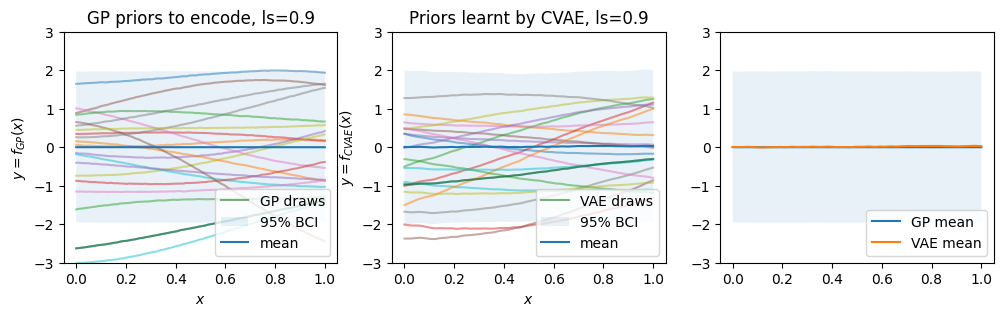

Frobenius norm = 3.18365164886965
MMD, multiscale = 0.10972933
MMD, rbf = 0.24794723


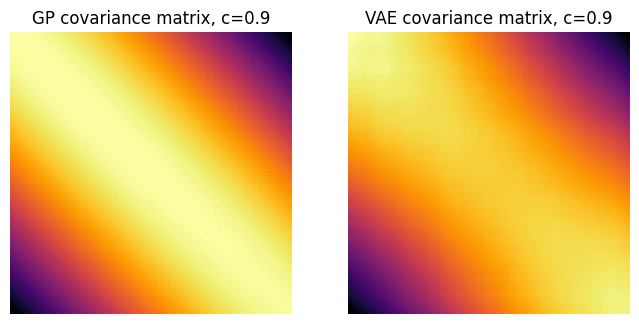

In [ ]:
# 4).
demo_plots(conditional=True, ls=0.9)

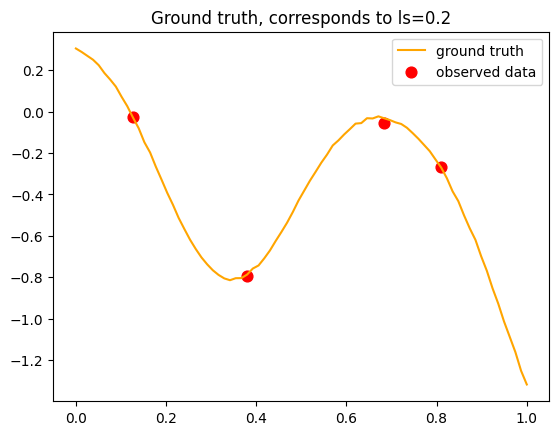

In [ ]:
# Define x and initialize random keys
x, y, ls = train_ds.get_item(0)  # Use get_item instead of indexing directly

rng_key_draw = jax.random.PRNGKey(1)
rng_key, rng_key_post, rng_key_preds, rng_key_draw = jax.random.split(rng_key_draw, 4)

# GP Predictive sampling
gp_predictive = Predictive(GP, num_samples=1)
draws = gp_predictive(rng_key_draw, x=x, jitter=1e-6,
                      noise=True, length=args["true_ls"], var=1)

gp_draw = draws['f'].T
y_draw = draws['y'].T

# Define observed indices and select observed data points
obs_idx_lst = [
    # [10, 32, 36, 48, 53, 70, 85],  # for ls=0.05
    # [5, 10, 20, 33, 44],           # for n=50, ls=0.2
    # [25, 28, 70],                  # for n=80, ls=0.3
    [10, 30, 54, 64],                # for n=80, ls=0.2
    # [15, 54, 63]                   # for n=80, ls=0.5
]
i = 0  # Choosing the first set of indices

obs_idx = jnp.array(obs_idx_lst[i])
y_obs = y_draw[obs_idx, 0]
x_obs = x[np.array(obs_idx)]

# Store observed data in args
args['y_obs'] = y_obs
args['obs_idx'] = obs_idx
args['x_obs'] = x_obs

# Plot ground truth and observed points
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.title('Ground truth, corresponds to ls=' + str(args["true_ls"]))
plt.legend()
plt.show()


In [ ]:
# Assuming `params` contains the initialized or trained parameters of the model
# Here, `params` would be obtained from `model.init` or during training.

# Extract decoder parameters
decoder_params = params['params']['decoder']

# Access specific layers within the decoder
W1 = decoder_params['Dense_0']['kernel']  # Equivalent to `weight` in PyTorch
B1 = decoder_params['Dense_0']['bias']
W2 = decoder_params['Dense_1']['kernel']
B2 = decoder_params['Dense_1']['bias']

# Convert parameters to NumPy arrays if needed
W1 = np.array(W1)
B1 = np.array(B1)
W2 = np.array(W2)
B2 = np.array(B2)

print("W1 shape:", W1.shape)
print("B1 shape:", B1.shape)
print("W2 shape:", W2.shape)
print("B2 shape:", B2.shape)
print(W1)

W1 shape: (41, 60)
B1 shape: (60,)
W2 shape: (60, 80)
B2 shape: (80,)
[[-3.1034162e-03  2.5456008e-03 -3.3157510e-03 ... -3.2602577e-03
   1.1463102e-03  1.1551244e-03]
 [ 1.1838294e-03  5.3771120e-03  2.2843722e-03 ...  5.2240198e-03
  -1.2912908e-02 -1.2344645e-02]
 [-8.6878501e-03  6.1847395e-03 -2.3185692e-03 ...  6.3802563e-03
   3.5267274e-03 -4.4637350e-03]
 ...
 [-7.1458910e-03  5.1799612e-03  3.8530678e-03 ... -3.6309166e-03
   4.8096091e-03 -3.7862149e-03]
 [-8.0672726e-03 -1.3830791e-03  3.8467881e-03 ...  4.2928974e-03
  -6.9363117e-03  1.6664163e-03]
 [ 3.3981648e-01 -6.0280743e+00 -3.2701035e+00 ... -1.0747600e-01
   8.3362323e-01 -1.2358417e-01]]


In [ ]:
def c_decoder_numpy(z, W1, B1, W2, B2, c=None):
    """Conditional decoder function using two linear layers."""
    def linear(z, W, B):
        return jnp.matmul(z, W) + B

    # Concatenate conditional input `c` if provided
    if c is not None:
        c = jnp.array(c).reshape(1)
        z = jnp.concatenate([z, c], axis=0)

    # Apply the first layer with ReLU activation
    hidden = jax.nn.relu(linear(z, W1, B1))
    # Output layer
    out = linear(hidden, W2, B2)
    return out


def numpyro_model(z_dim, conditional=False,  y=None, obs_idx=None, c=None,):
    if c is None and conditional==True:
        c = numpyro.sample("c", npdist.Uniform(0.01,0.99))

    z = numpyro.sample("z", npdist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))

    f = numpyro.deterministic("f", c_decoder_numpy(z, W1, B1, W2, B2, c))

    sigma = numpyro.sample("sigma", npdist.HalfNormal(0.1))

    if y is None: # durinig prediction
        y_pred = numpyro.sample("y_pred", npdist.Normal(f, sigma))
    else: # during inference
        y = numpyro.sample("y", npdist.Normal(f[obs_idx], sigma), obs=y)

In [ ]:
def run_mcmc_vae(rng_key, numpyro_model, args, verbose=True, c=None, conditional=False):
    start = time.time()

    init_strategy = init_to_median(num_samples=100)
    print(numpyro_model)
    kernel = NUTS(numpyro_model, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=args["num_warmup"],
        num_samples=args["num_samples"],
        num_chains=args["num_chains"],
        thinning=args["thinning"],
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    start = time.time()
    print(rng_key, args["z_dim"], conditional, args["y_obs"], args["obs_idx"], c )
    mcmc.run(rng_key, args["z_dim"], conditional, args["y_obs"], args["obs_idx"], c )
    t_elapsed = time.time() - start
    if verbose:
        mcmc.print_summary(exclude_deterministic=False)

    print("\nMCMC elapsed time:", round(t_elapsed), "s")
    ss = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain=True))
    r = np.mean(ss['f']['n_eff'])
    print("Average ESS for all VAE-GP effects : " + str(round(r)))

    return (mcmc, mcmc.get_samples(), t_elapsed)

In [ ]:
print(args["obs_idx"])

NameError: name 'args' is not defined

In [ ]:
args.keys()

dict_keys(['seed', 'conditional', 'input_dim', 'hidden_dim', 'z_dim', 'batch_size', 'samples', 'learning_rate', 'n_epochs', 'new_data', 'train_vae', 'save_vae', 'load_vae', 'num_warmup', 'num_samples', 'num_chains', 'thinning', 'true_ls', 'y_obs', 'obs_idx', 'x_obs'])

In [ ]:
print(rng_key)

[ 869452973 4133157646]


In [ ]:
mcmc_vae, mcmc_vae_samples, t_elapsed = run_mcmc_vae(jax.random.PRNGKey(6), numpyro_model, args, conditional=True)

<function numpyro_model at 0x7c9de8647eb0>
[0 6] 40 True [-0.02660892 -0.79433453 -0.05735491 -0.26568583] [10 30 54 64] None


<ipython-input-79-b9ac921573d3>:7: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 7000/7000 [00:44<00:00, 156.13it/s, 255 steps of size 1.46e-02. acc. prob=0.85]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      0.20      0.15      0.19      0.01      0.31   1042.06      1.00
      f[0]      0.22      0.57      0.31     -0.72      1.12    875.72      1.00
      f[1]      0.21      0.58      0.31     -0.75      1.12    954.68      1.00
      f[2]      0.20      0.57      0.29     -0.80      1.04   1025.39      1.00
      f[3]      0.18      0.54      0.26     -0.75      0.99   1077.00      1.00
      f[4]      0.15      0.49      0.23     -0.71      0.86   1117.49      1.00
      f[5]      0.12      0.42      0.19     -0.62      0.75   1170.53      1.00
      f[6]      0.09      0.35      0.15     -0.53      0.62   1269.13      1.00
      f[7]      0.06      0.28      0.11     -0.45      0.48   1413.60      1.00
      f[8]      0.03      0.21      0.06     -0.34      0.36   1642.64      1.00
      f[9]     -0.01      0.15      0.02     -0.26      0.23   2949.54      1.00
     f[10]     -0.05      0

(-2.0, 1.0)

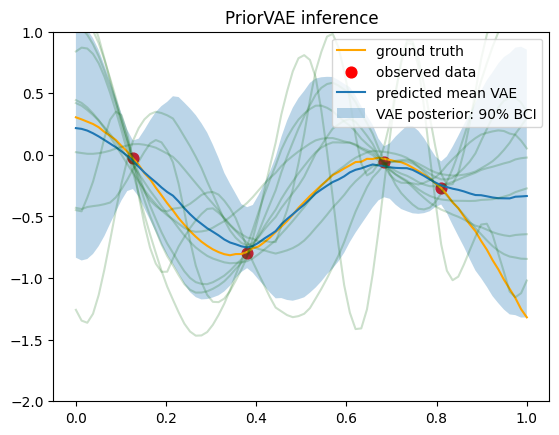

In [ ]:
predictive = Predictive(numpyro_model, mcmc_vae_samples)
predictions_vae = predictive(jax.random.PRNGKey(7),  args["z_dim"], True, args["y_obs"], args["obs_idx"] )["f"]

mean_post_pred_vae = jnp.mean(predictions_vae, axis=0)
hpdi_post_pred_vae = hpdi(predictions_vae, 0.9)
percentiles_vae = np.percentile(predictions_vae, [5.0, 95.0], axis=0)

N_lines = 10
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.plot(x, mean_post_pred_vae, label="predicted mean VAE")

plt.fill_between(x, percentiles_vae[0, :], percentiles_vae[1, :], alpha=0.3, interpolate=True, label="VAE posterior: 90% BCI")
for j in range(N_lines):
    itr = int(predictions_vae.shape[0]/N_lines)
    plt.plot(x, predictions_vae[j* itr,:], alpha=0.2, color="darkgreen", label="")
    #plt.plot(x, predictions_vae[j,:], alpha=0.2, color="darkgreen", label="")

plt.title('PriorVAE inference')
plt.legend(loc=1)
plt.ylim([-2, 1])


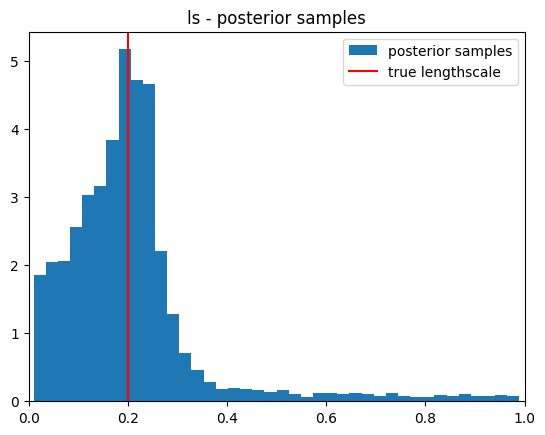

In [ ]:
c_samps = mcmc_vae_samples['c']
plt.hist(c_samps, density=True, label = 'posterior samples', bins=40)
plt.axvline(x = args["true_ls"], color = 'red', label = 'true lengthscale')
plt.xlim(0,1)
plt.title('ls - posterior samples')
plt.legend()

array([[<Axes: title={'center': 'c'}>, <Axes: title={'center': 'c'}>]],
      dtype=object)

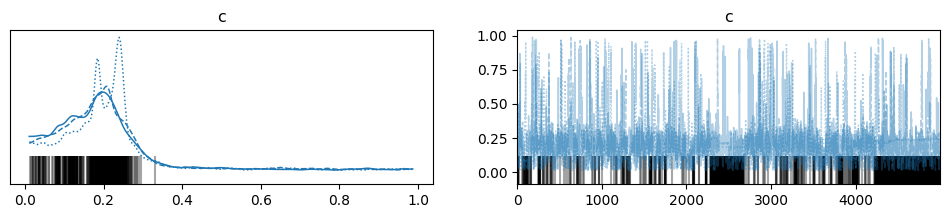

In [ ]:
import arviz as az
az_data = az.from_numpyro(mcmc_vae)
#az.plot_trace(az_data, var_names=('f'), filter_vars="like")
az.plot_trace(az_data, var_names=('c'), filter_vars="like")

In [ ]:
true_ls_lst = [0.2, 0.3, 0.5]
rng_key_lst = [jax.random.PRNGKey(1), jax.random.PRNGKey(2), jax.random.PRNGKey(1)]

obs_idx_lst = [
    [10, 30, 54, 64],
    [25, 28, 70],
    [15, 54, 63]
]

mean_post_pred_lst = []
perc_post_pred_lst = []
x_obs_lst = []
y_obs_lst = []
predictions_lst = []
c_samps_lst = []
gp_draw_lst = []

# Generate x values from the dataset
x = train_ds.get_item(0)[0]  # Assuming train_ds is accessed via get_item

for i in range(len(true_ls_lst)):
    true_ls = true_ls_lst[i]
    rng_key_draw = rng_key_lst[i]

    # Generate random keys for sampling and inference
    rng_key, rng_key_post, rng_key_preds, rng_key_draw = jax.random.split(rng_key_draw, 4)

    # GP Predictive sampling
    gp_predictive = Predictive(GP, num_samples=1)
    draws = gp_predictive(rng_key_draw, x=x, jitter=1e-6, noise=True, length=true_ls, var=1)

    gp_draw = draws['f'].T
    y_draw = draws['y'].T

    # Select observed indices for inference
    obs_idx = jnp.array(obs_idx_lst[i])
    y_obs = y_draw[obs_idx, 0]
    x_obs = x[obs_idx]

    # Update arguments for MCMC
    args['y_obs'] = y_obs
    args['obs_idx'] = obs_idx
    args['x_obs'] = x_obs

    # Run MCMC inference
    mcmc_vae, mcmc_vae_samples, t_elapsed = run_mcmc_vae(rng_key_post, numpyro_model, args, conditional=True)

    # Posterior predictions
    predictive = Predictive(numpyro_model, mcmc_vae_samples)
    predictions_vae = predictive(rng_key_preds, args["z_dim"], True, c=None)["f"]

    mean_post_pred_vae = jnp.mean(predictions_vae, axis=0)
    percentiles_vae = np.percentile(predictions_vae, [5.0, 95.0], axis=0)
    c_samps = mcmc_vae_samples['c']

    # Store results
    mean_post_pred_lst.append(mean_post_pred_vae)
    perc_post_pred_lst.append(percentiles_vae)
    gp_draw_lst.append(gp_draw)
    x_obs_lst.append(x_obs)
    y_obs_lst.append(y_obs)
    predictions_lst.append(predictions_vae)
    c_samps_lst.append(c_samps)


<ipython-input-79-b9ac921573d3>:7: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


<function numpyro_model at 0x7c9de8647eb0>
[ 261504626 4112007671] 40 True [-0.02660892 -0.79433453 -0.05735491 -0.26568583] [10 30 54 64] None


sample: 100%|██████████| 7000/7000 [00:46<00:00, 150.60it/s, 255 steps of size 1.58e-02. acc. prob=0.77]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      0.20      0.15      0.18      0.01      0.31    905.07      1.00
      f[0]      0.15      0.59      0.27     -0.92      1.11    251.88      1.01
      f[1]      0.14      0.60      0.26     -1.01      1.07    255.63      1.01
      f[2]      0.13      0.59      0.24     -1.21      0.82    257.90      1.01
      f[3]      0.11      0.55      0.22     -1.11      0.78    267.46      1.01
      f[4]      0.10      0.50      0.19     -0.99      0.71    281.08      1.01
      f[5]      0.08      0.43      0.16     -0.80      0.65    305.67      1.01
      f[6]      0.06      0.36      0.12     -0.64      0.53    355.35      1.01
      f[7]      0.04      0.28      0.09     -0.48      0.43    457.62      1.01
      f[8]      0.01      0.21      0.05     -0.34      0.34    746.03      1.01
      f[9]     -0.01      0.15      0.01     -0.27      0.22   3142.49      1.00
     f[10]     -0.05      0

<ipython-input-79-b9ac921573d3>:7: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


<function numpyro_model at 0x7c9de8647eb0>
[404458523   8483201] 40 True [ 0.73704606  0.7017858  -2.2349658 ] [25 28 70] None


sample: 100%|██████████| 7000/7000 [00:31<00:00, 218.82it/s, 127 steps of size 2.62e-02. acc. prob=0.80]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      0.21      0.13      0.20      0.01      0.37   1577.98      1.01
      f[0]      0.35      0.78      0.35     -0.95      1.65   7233.59      1.00
      f[1]      0.37      0.80      0.38     -0.92      1.75   7250.09      1.00
      f[2]      0.38      0.81      0.39     -0.97      1.72   7201.36      1.00
      f[3]      0.39      0.80      0.41     -0.90      1.77   7032.54      1.00
      f[4]      0.40      0.79      0.43     -0.93      1.70   6784.79      1.00
      f[5]      0.41      0.78      0.45     -0.90      1.69   6624.73      1.00
      f[6]      0.43      0.76      0.46     -0.86      1.68   6542.10      1.00
      f[7]      0.45      0.75      0.48     -0.77      1.70   6565.92      1.00
      f[8]      0.47      0.73      0.50     -0.67      1.74   6648.67      1.00
      f[9]      0.49      0.71      0.52     -0.63      1.72   6680.41      1.00
     f[10]      0.51      0

<ipython-input-79-b9ac921573d3>:7: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


<function numpyro_model at 0x7c9de8647eb0>
[ 261504626 4112007671] 40 True [ 0.06046987 -0.6373818  -0.607956  ] [15 54 63] None


sample: 100%|██████████| 7000/7000 [00:08<00:00, 826.57it/s, 3 steps of size 1.14e-02. acc. prob=0.00] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      0.55      0.18      0.55      0.24      0.90   1000.00      1.00
      f[0]      0.33      0.29      0.45     -0.10      0.63     10.65      1.08
      f[1]      0.31      0.28      0.42     -0.11      0.59     12.15      1.07
      f[2]      0.29      0.27      0.40     -0.10      0.55     13.63      1.07
      f[3]      0.27      0.26      0.37     -0.10      0.52     14.91      1.06
      f[4]      0.26      0.25      0.35     -0.11      0.47     15.87      1.06
      f[5]      0.24      0.23      0.33     -0.09      0.46     16.92      1.05
      f[6]      0.22      0.22      0.30     -0.09      0.43     17.99      1.05
      f[7]      0.20      0.20      0.28     -0.08      0.41     18.86      1.05
      f[8]      0.18      0.19      0.25     -0.07      0.39     20.60      1.04
      f[9]      0.16      0.17      0.22     -0.08      0.35     23.12      1.04
     f[10]      0.15      0

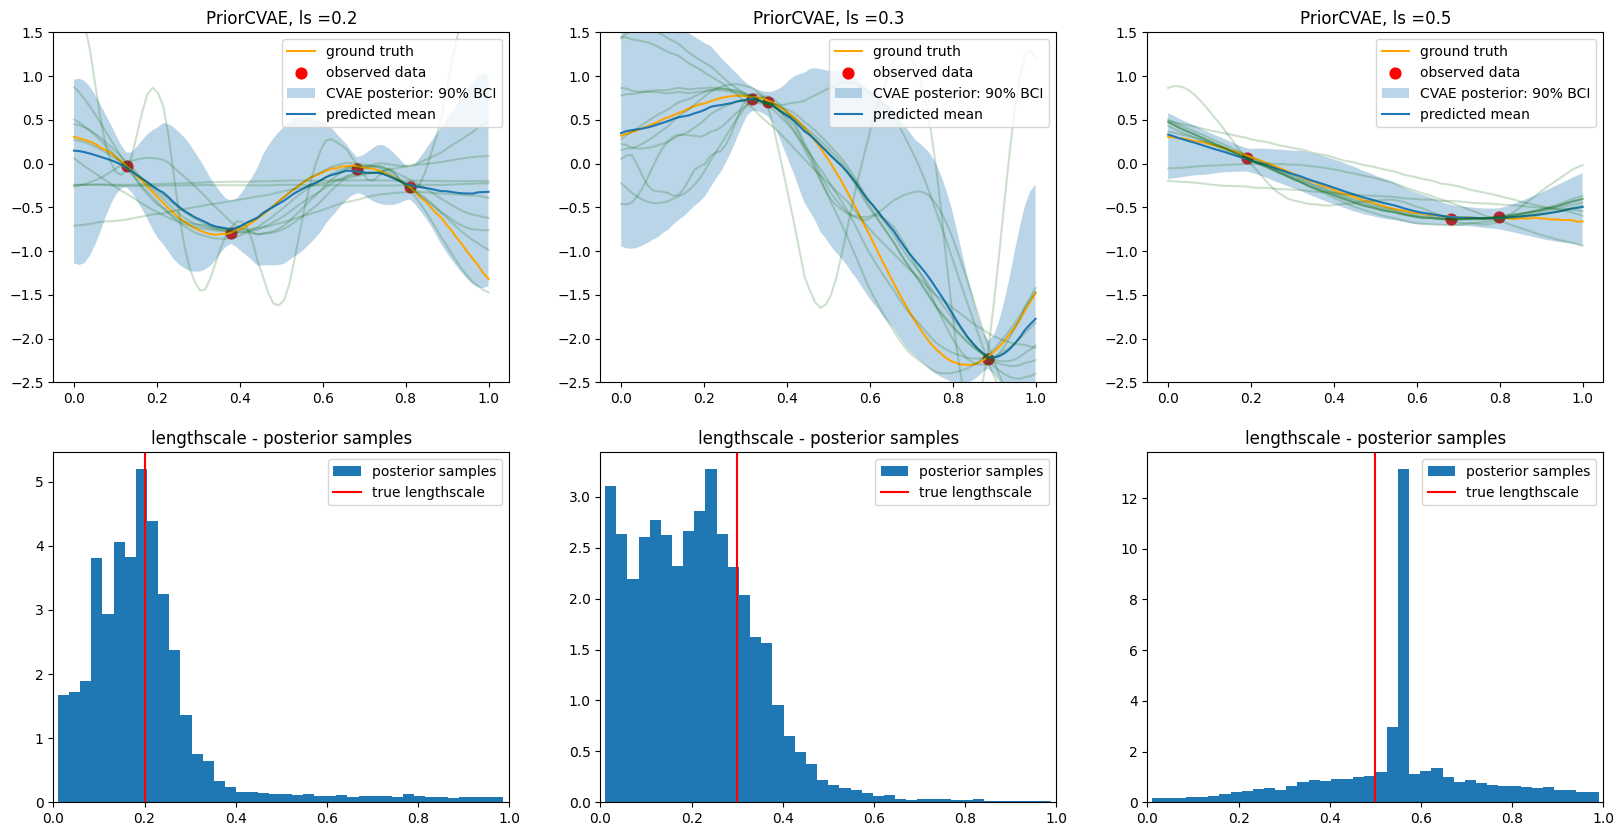

In [ ]:
# plot results
fig, axs = plt.subplots(nrows=2, ncols=len(mean_post_pred_lst), figsize=(20,10))
_min, _max = np.amin(mean_post_pred_lst), np.amax(mean_post_pred_lst)

for i in range(len(mean_post_pred_lst)):
    axs[0,i].plot(x, gp_draw_lst[i], label="ground truth", color="orange")
    axs[0,i].scatter(x_obs_lst[i], y_obs_lst[i], color="red", label="observed data", s=60)
    axs[0,i].fill_between(x,
                      perc_post_pred_lst[i][0], perc_post_pred_lst[i][1],
                      alpha=0.3, interpolate=True, label="CVAE posterior: 90% BCI")
    axs[0,i].plot(x, mean_post_pred_lst[i], label="predicted mean")
    for j in range(N_lines):
        itr = int(predictions_lst[i].shape[0]/N_lines)
        axs[0,i].plot(x, predictions_lst[i][j* itr,:], alpha=0.2, color="darkgreen", label="")
    axs[0,i].set_title('PriorCVAE, ls =' + str(true_ls_lst[i]))
    axs[0,i].legend(loc=1)
    axs[0, i].set_ylim(-2.5, 1.5)

    axs[1,i].hist(c_samps_lst[i], density=True, label = 'posterior samples', bins=40)
    axs[1,i].axvline(x = true_ls_lst[i], color = 'red', label = 'true lengthscale')
    axs[1,i].set_xlim(0,1)
    axs[1,i].set_title('lengthscale - posterior samples')
    axs[1,i].legend()
